<p style="text-align:center">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="300" alt="Skills Network Logo">
</p>

# Final Project: Building a Rainfall Prediction Classifier
Course clompletion requirement

## Objectives

After completing this lab you will be able to:

* Explore and perform feature engineering on a real-world data set
* Build a classifier pipeline and optimize it using grid search cross validation
* Evaluate your model by interpreting various performance metrics and visualizations
* Implement a different classifier by updating your pipeline
* Use an appropriate set of parameters to search over in each case

## Author

<a href="https://www.linkedin.com/in/pedro-henrique-amorim-de-azevedo-07507b179/" target="_blank">Pedro Azevedo</a>

The dataset you'll use in this project can be downloaded from Kaggle at [https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package?resource=download&select=weatherAUS.csv)  
Column definitions were gathered from [http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml](http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01)  

The dataset contains observations of weather metrics for each day from 2008 to 2017, and includes the following fields:

| Field         | Description                                           | Unit            | Type   |
| :------------ | :---------------------------------------------------- | :-------------- | :----- |
| Date          | Date of the Observation in YYYY-MM-DD                 | Date            | object |
| Location      | Location of the Observation                           | Location        | object |
| MinTemp       | Minimum temperature                                   | Celsius         | float  |
| MaxTemp       | Maximum temperature                                   | Celsius         | float  |
| Rainfall      | Amount of rainfall                                    | Millimeters     | float  |
| Evaporation   | Amount of evaporation                                 | Millimeters     | float  |
| Sunshine      | Amount of bright sunshine                             | hours           | float  |
| WindGustDir   | Direction of the strongest gust                       | Compass Points  | object |
| WindGustSpeed | Speed of the strongest gust                           | Kilometers/Hour | object |
| WindDir9am    | Wind direction averaged over 10 minutes prior to 9am  | Compass Points  | object |
| WindDir3pm    | Wind direction averaged over 10 minutes prior to 3pm  | Compass Points  | object |
| WindSpeed9am  | Wind speed averaged over 10 minutes prior to 9am      | Kilometers/Hour | float  |
| WindSpeed3pm  | Wind speed averaged over 10 minutes prior to 3pm      | Kilometers/Hour | float  |
| Humidity9am   | Humidity at 9am                                       | Percent         | float  |
| Humidity3pm   | Humidity at 3pm                                       | Percent         | float  |
| Pressure9am   | Atmospheric pressure reduced to mean sea level at 9am | Hectopascal     | float  |
| Pressure3pm   | Atmospheric pressure reduced to mean sea level at 3pm | Hectopascal     | float  |
| Cloud9am      | Fraction of the sky obscured by cloud at 9am          | Eights          | float  |
| Cloud3pm      | Fraction of the sky obscured by cloud at 3pm          | Eights          | float  |
| Temp9am       | Temperature at 9am                                    | Celsius         | float  |
| Temp3pm       | Temperature at 3pm                                    | Celsius         | float  |
| RainToday     | If there was at least 1mm of rain today               | Yes/No          | object |
| RainTomorrow  | If there is at least 1mm of rain tomorrow             | Yes/No          | object |

## Install and import the required libraries

In [1]:
!pip install -q numpy 
!pip install -q pandas
!pip install -q matplotlib
!pip install -q scikit-learn==1.5.0
!pip install -q seaborn
!pip install -q xgboost
!pip install -q umap-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
# from umap import UMAP

## Load the data

In [83]:
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"
df = pd.read_csv(url)
df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

# Perform EDA on data
Exploratory Data Analysis

In [84]:
# Get number of entries for each column
df.count()

Date             145460
Location         145460
MinTemp          143975
MaxTemp          144199
Rainfall         142199
Evaporation       82670
Sunshine          75625
WindGustDir      135134
WindGustSpeed    135197
WindDir9am       134894
WindDir3pm       141232
WindSpeed9am     143693
WindSpeed3pm     142398
Humidity9am      142806
Humidity3pm      140953
Pressure9am      130395
Pressure3pm      130432
Cloud9am          89572
Cloud3pm          86102
Temp9am          143693
Temp3pm          141851
RainToday        142199
RainTomorrow     142193
dtype: int64

In [85]:
# Get missing values count
df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [86]:
df.describe()

MinTemp        MaxTemp       Rainfall   Evaporation  \
count  143975.000000  144199.000000  142199.000000  82670.000000   
mean       12.194034      23.221348       2.360918      5.468232   
std         6.398495       7.119049       8.478060      4.193704   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.900000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  75625.000000  135197.000000  143693.000000  142398.000000   
mean       7.611178      40.035230      14.043426      18.662657   
std        3.785483      13.607062       8.915375       8.809800   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.800000      31.000000       7.000000      13.000000   
50%        8.400000      39.000000      13.000000      19.000000   
75%       10.600000      48.000000      19.000000      24.000000   
max       14.500000     135.000000     130.000000      87.000000   

         Humidity9am    Humidity3pm   Pressure9am    Pressure3pm  \
count  142806.000000  140953.000000  130395.00000  130432.000000   
mean       68.880831      51.539116    1017.64994    1015.255889   
std        19.029164      20.795902       7.10653       7.037414   
min         0.000000       0.000000     980.50000     977.100000   
25%        57.000000      37.000000    1012.90000    1010.400000   
50%        70.000000      52.000000    1017.60000    1015.200000   
75%        83.000000      66.000000    1022.40000    1020.000000   
max       100.000000     100.000000    1041.00000    1039.600000   

           Cloud9am      Cloud3pm        Temp9am       Temp3pm  
count  89572.000000  86102.000000  143693.000000  141851.00000  
mean       4.447461      4.509930      16.990631      21.68339  
std        2.887159      2.720357       6.488753       6.93665  
min        0.000000      0.000000      -7.200000      -5.40000  
25%        1.000000      2.000000      12.300000      16.60000  
50%        5.000000      5.000000      16.700000      21.10000  
75%        7.000000      7.000000      21.600000      26.40000  
max        9.000000      9.000000      40.200000      46.70000

In [87]:
df = df.dropna()
df.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

# Consideratons about the dataset

### Data leakage
In this dataset we have columns that contain data from future, which can lead to data leakage. 
This is the case of the 'RainTomorrow' column. To solve this, we can legitimately change the name of rain columns and change our approach to predict today's rainfall with all available data.

In [88]:
df = df.rename(
    columns={
        'RainToday': 'RainYesterday',
        'RainTomorrow': 'RainToday'
    }
)

# Data granularity
Weather patterns change a lot, especially in a large location as Autralia. Our model would have a poor predictability and big complexity do to so. To avoid this e keep things simple, we need to reduce our attention to a smaller region.

Let's keep focused on Melbourne and it's airport which is located only 18km from there.

In [89]:
loc_mask = df['Location'].isin(['Melbourne', 'MelbourneAirport', 'Watsonia'])
df = df[loc_mask]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7557 non-null   object 
 1   Location       7557 non-null   object 
 2   MinTemp        7557 non-null   float64
 3   MaxTemp        7557 non-null   float64
 4   Rainfall       7557 non-null   float64
 5   Evaporation    7557 non-null   float64
 6   Sunshine       7557 non-null   float64
 7   WindGustDir    7557 non-null   object 
 8   WindGustSpeed  7557 non-null   float64
 9   WindDir9am     7557 non-null   object 
 10  WindDir3pm     7557 non-null   object 
 11  WindSpeed9am   7557 non-null   float64
 12  WindSpeed3pm   7557 non-null   float64
 13  Humidity9am    7557 non-null   float64
 14  Humidity3pm    7557 non-null   float64
 15  Pressure9am    7557 non-null   float64
 16  Pressure3pm    7557 non-null   float64
 17  Cloud9am       7557 non-null   float64
 18  Cloud3pm

# Outliers

Typically, the presence of outliers makes it difficult to fit the ML model to the dataset. Let's plot the numerical columns using box plot and take a look at them.

The function `plot_boxplots` plots every numeric column in the DataFrame.

The function `identify_outliers` returns a list with all detected outliers using the Interquartile Range (IQR) method.

In [90]:
def plot_boxplots(df, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []
        
	# Get only numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    # Calculate the number of rows and columns for the subplot
    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 16))
    
    # Plot each boxplot
    for i, col in enumerate(numeric_cols):
        row_idx = i // n_cols
        col_idx = i % n_cols
        
        # Create the boxplot
        sns.boxplot(y=df[col], ax=axes[row_idx, col_idx])
        axes[row_idx, col_idx].set_title(f'Boxplot of {col}')
        axes[row_idx, col_idx].set_ylabel('Values')
        
        # Add labels for outliers
        outliers = outliers_column(df[col])
        if len(outliers) > 0:
            axes[row_idx, col_idx].text(0.02, 0.95, f'Outliers: {len(outliers)}', 
                                      transform=axes[row_idx, col_idx].transAxes)
    
    # Remove empty subplots
    for i in range(len(numeric_cols), n_rows * n_cols):
        row_idx = i // n_cols
        col_idx = i % n_cols
        fig.delaxes(axes[row_idx, col_idx])
    
    plt.tight_layout()
    plt.show()
    

def outliers_column(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers.tolist()


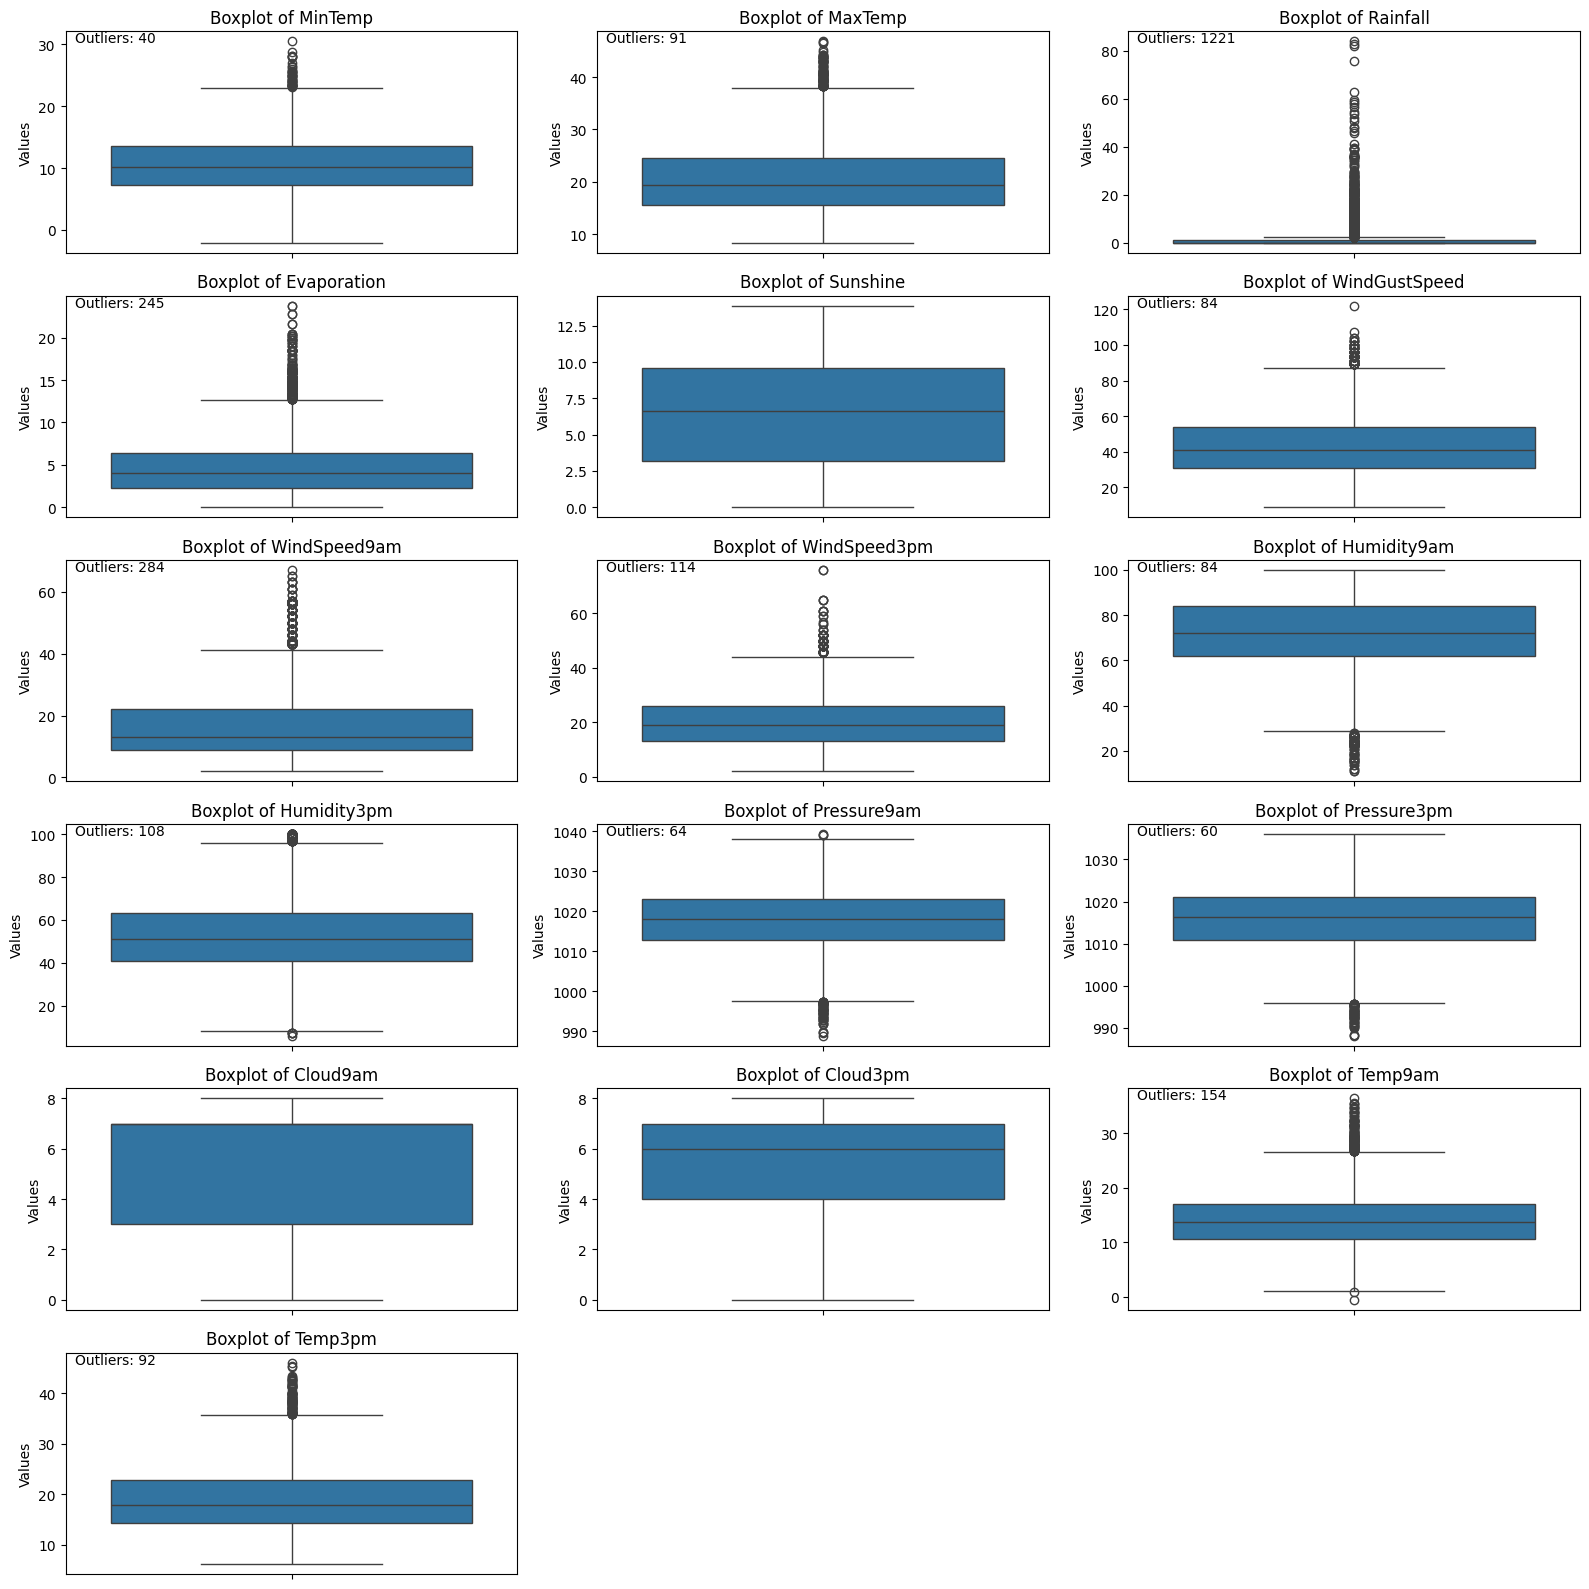

In [91]:
# Plot all coluns except the target one
plot_boxplots(df, exclude_cols=['RainToday'])

## Replacing outliers with Winsorization

As we can see, we have many columns with outliers. In this specific case, we cannot change some columns because even the outliers carry important information. In the case of `Pressure9am` and `Pressure3pm`, we know that extreme changes in atmospheric pressure usually anticipate rain. Same goes for temperatures, humidity and clouds.

Let's use a function to apply Winsorization to some columns where we know there may be some outliers due to measurement failures. Winsorized mean is a method of averaging that initially replaces the smallest and largest values with the observations closest to them. This is done to limit the effect of outliers or abnormal extreme values, on the calculation.

Good candidates are `Rainfall`, `WindGustSpeed`, `Evaporation` and `WindSpeed3pm`. 

In [92]:
def winsorize_outliers(df: pd.DataFrame, cols: list[str]):
	# Create a deep copy of the dataframe to avoid modifying the original
	df_cleaned = df.copy()

	for col_name in cols:
		col_values = df[col_name]

		# Calculate Q1, Q2 and IQR
		q1 = col_values.quantile(0.25)
		q3 = col_values.quantile(0.75)
		iqr = q3 - q1 # Interquartile range

		# Define bounds for outliers
		lower_bound = q1 - (1.5 * iqr)
		upper_bound = q3 + (1.5 * iqr)

		# Values below the lower bound are replaced by the lower bound itself
		df_cleaned.loc[df_cleaned[col_name] < lower_bound, col_name] = lower_bound
        
        # Values above the upper bound are replaced by the upper bound itself
		df_cleaned.loc[df_cleaned[col_name] > upper_bound, col_name] = upper_bound

	return df_cleaned

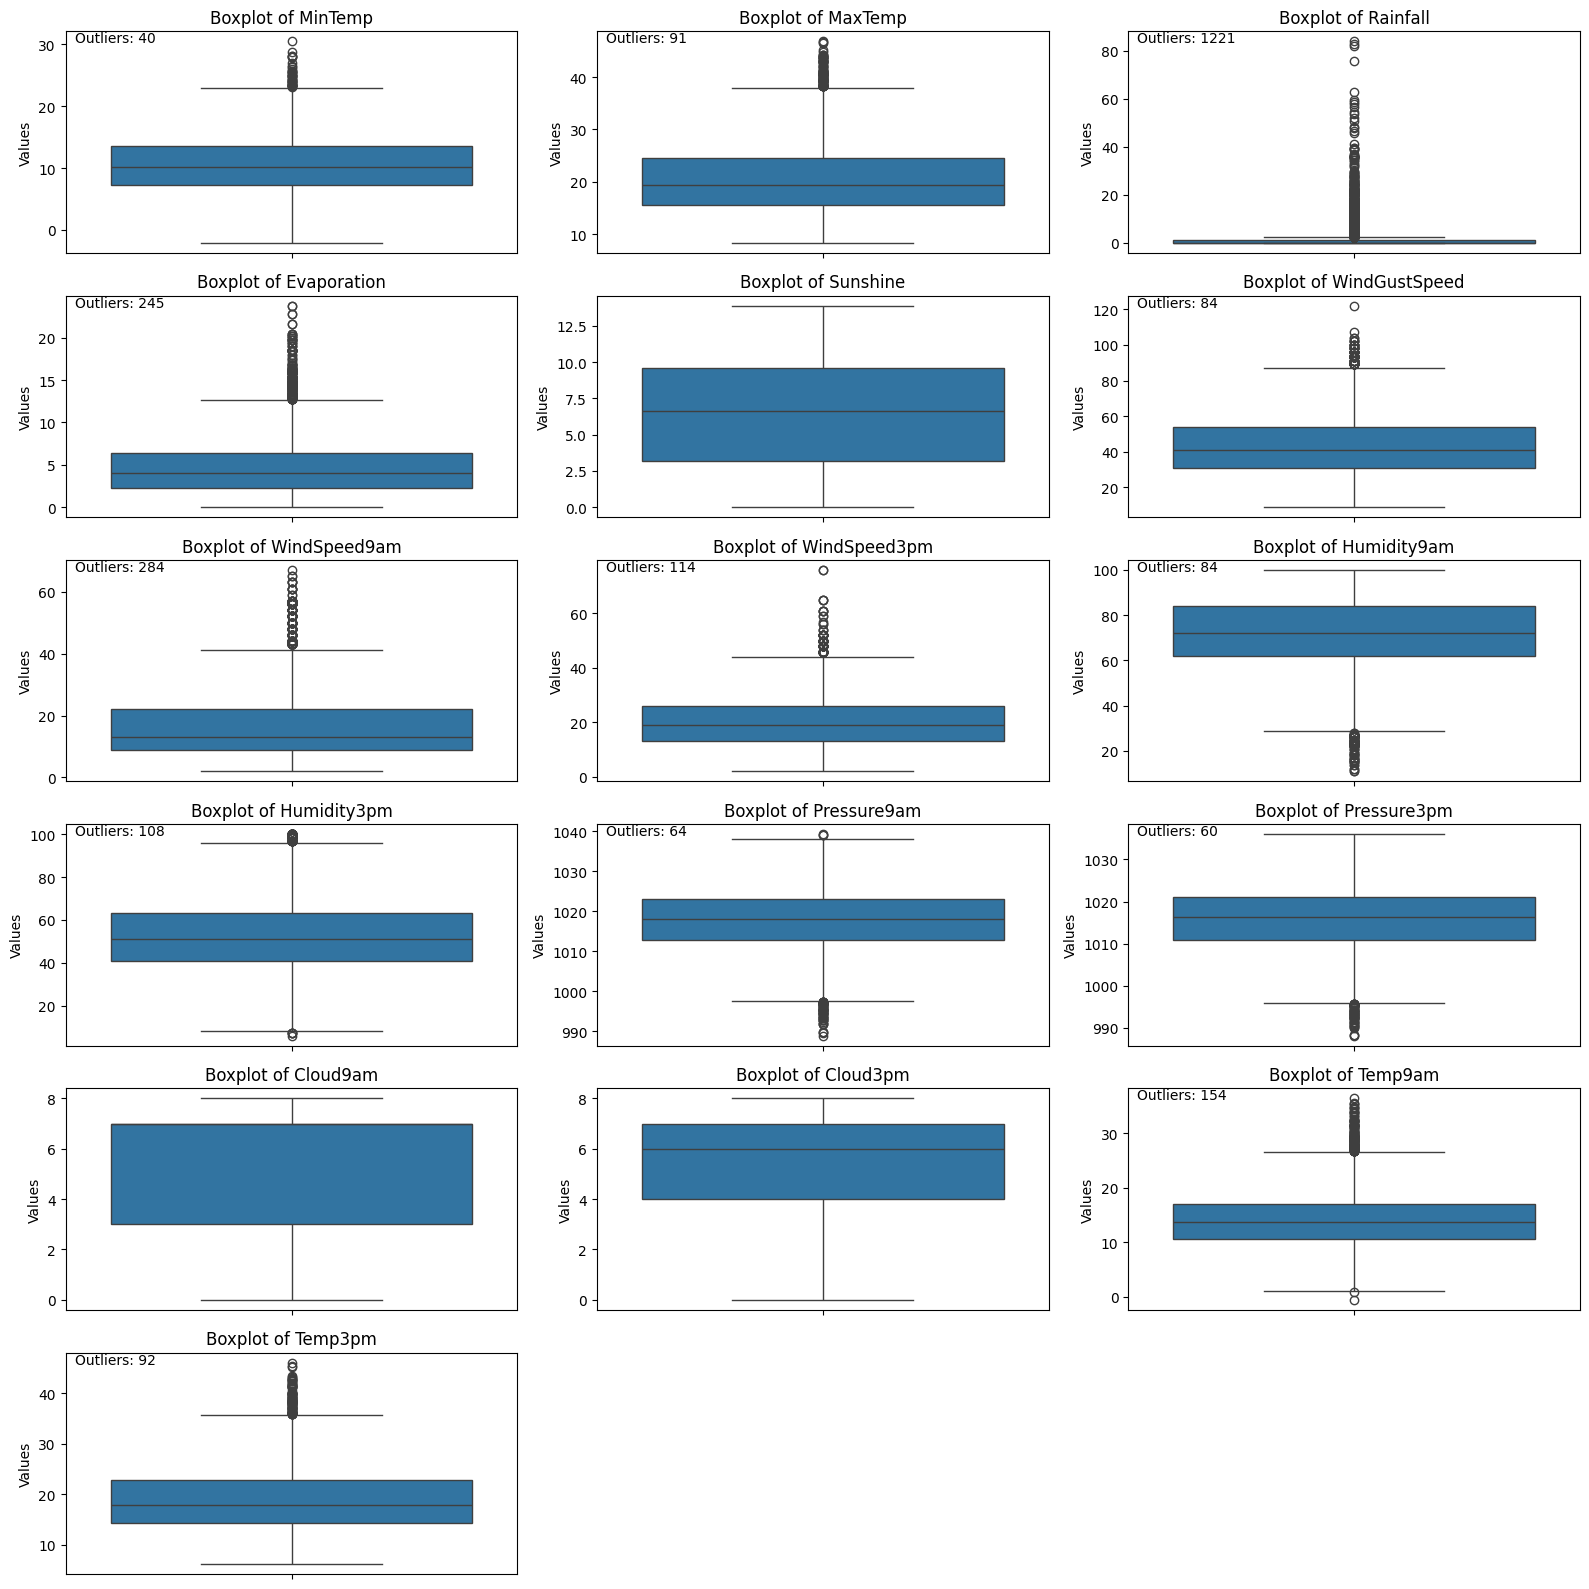

In [ ]:
# Get a new dataframe with winzorized values
df = winsorize_outliers(df, cols=['Rainfall', 'WindGustSpeed', 'Evaporation', 'WindSpeed3pm'])

# Let's take a look at the plots
plot_boxplots(df, exclude_cols=['RainToday'])

We can see that we obtained good results with the removal of outliers. Note through the plots that even after the treatment of outliers the distribution of the data remained similar.

# Removing Highly Correlated Columns


In [ ]:
def remove_collinear_features(df: pd.DataFrame, columns: list[str], threshold: float):
    # Calculate the correlation matrix
    corr_matrix = df[columns].corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            # To get an item via slicing: item = [item_row:item_row+1, item_col:item_col+1]
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            
            col = item.columns # Index object
            row = item.index # Index object
            val = abs(item.values) 

            if val >= threshold:
                # Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Remove duplicates
    drops = set(drop_cols)
    df = df.drop(columns=drops, axis=1)
    print('Removed Columns {}'.format(drops))
    return df

In [95]:
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
df = remove_collinear_features(df, numeric_cols, 0.80)

# Inspect the dataframe
df.head()

Removed Columns {'Pressure3pm', 'Temp3pm', 'Temp9am'}


Date          Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
64191  2009-01-01  MelbourneAirport     11.2     19.9       0.0          5.6   
64192  2009-01-02  MelbourneAirport      7.8     17.8       1.2          7.2   
64193  2009-01-03  MelbourneAirport      6.3     21.1       0.0          6.2   
64194  2009-01-04  MelbourneAirport      8.1     29.2       0.0          6.4   
64195  2009-01-05  MelbourneAirport      9.7     29.0       0.0          7.4   

       Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
64191       8.8          SW           69.0          W         SW   
64192      12.9         SSE           56.0         SW        SSE   
64193      10.5         SSE           31.0          E          S   
64194      12.5         SSE           35.0         NE        SSE   
64195      12.3          SE           33.0         SW        SSE   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
64191          33.0          43.0         55.0         37.0       1005.1   
64192          31.0          26.0         50.0         43.0       1018.0   
64193          13.0          19.0         51.0         35.0       1020.8   
64194           2.0          20.0         67.0         23.0       1016.2   
64195           9.0          20.0         51.0         31.0       1011.9   

       Cloud9am  Cloud3pm RainYesterday RainToday  
64191       7.0       7.0            No       Yes  
64192       6.0       7.0           Yes        No  
64193       1.0       7.0            No        No  
64194       5.0       4.0            No        No  
64195       6.0       2.0            No        No

# Creating a seasonality feature

Since weather patterns are seasonal, having different levels of predictability in each season, we can project the Date column into a Season column. In this step, we will transform the Date column into four unique categorical values ​​`Summer`, `Autumn`, `Winter`, `Spring`.

With this categorical approach, our model will fit better to our dataset.

In [96]:
def date_to_season(date):
    month = date.month
    if (month == 12) or (month == 1) or (month == 2):
        return 'Summer'
    elif month >= 3 and month <= 5:
        return 'Autumn'
    elif month >= 6 and month <= 8:
        return 'Winter'
    elif month >= 9 and month <= 11:
        return 'Spring'

In [97]:
df['Date'] = pd.to_datetime(df['Date'])

# Create Season col
df['Season'] = df['Date'].apply(date_to_season)

# Now drop Date col
df = df.drop(columns=['Date'])

df.sample(5)

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
79596          Watsonia      9.9     16.3       0.6          2.0       1.7   
79867          Watsonia     10.6     21.2       0.2          4.0       2.2   
70031         Melbourne      8.9     15.8       0.2          1.8       8.3   
66367  MelbourneAirport      8.2     25.1       0.0          5.2       3.8   
64380  MelbourneAirport      1.7     14.9       0.0          2.2       8.3   

      WindGustDir  WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  \
79596           N           28.0          W        WSW           4.0   
79867           N           46.0         NE          N           7.0   
70031           N           44.0          N          N          13.0   
66367           N           56.0          N        NNE          15.0   
64380           N           50.0        NNE          N          13.0   

       WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Cloud9am  \
79596           7.0         95.0         68.0       1022.6       7.0   
79867          17.0         68.0         61.0       1017.9       7.0   
70031          20.0         84.0         58.0       1026.8       1.0   
66367          26.0         78.0         35.0       1015.3       6.0   
64380          19.0         69.0         50.0       1030.0       6.0   

       Cloud3pm RainYesterday RainToday  Season  
79596       7.0            No        No  Winter  
79867       7.0            No       Yes  Autumn  
70031       7.0            No        No  Winter  
66367       7.0            No        No  Autumn  
64380       4.0            No        No  Winter

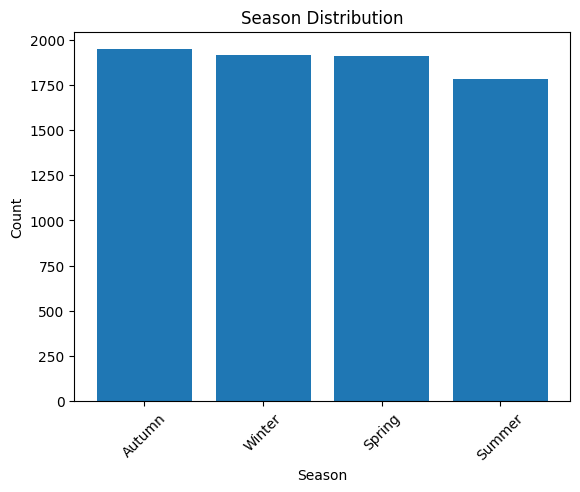

In [98]:
# Let's see how distributed is our new feature across the dataset
season_counts = df['Season'].value_counts()

plt.bar(season_counts.index, season_counts.values)
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Season Distribution')
plt.xticks(rotation=45)  # Rotate labels for better readability if needed
plt.show()

As we can see, the new feature is well distributed and can easily be used by our model without further configuration.

# Define feature and target dataframes

For training purposes, let's transform the No e and Yes columns to 0 and 1.

In [99]:
df["RainToday"] = df["RainToday"].map({"No": 0, "Yes": 1})

In [100]:
X = df.drop(columns=['RainToday'], axis=1)
y = df['RainToday']

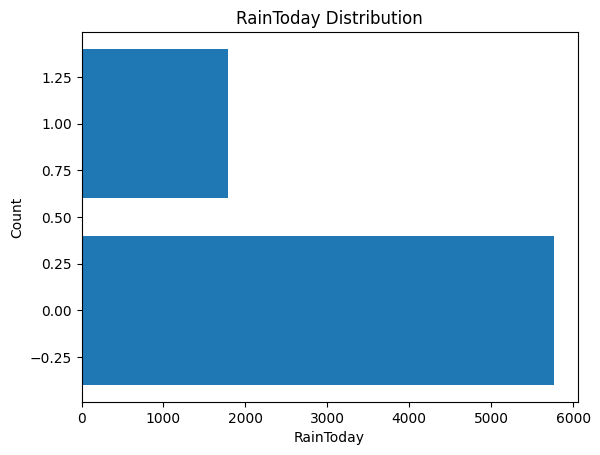

In [101]:
target_count = y.value_counts()

plt.barh(target_count.index, target_count.values)
plt.xlabel('RainToday')
plt.ylabel('Count')
plt.title('RainToday Distribution')
plt.show()

# Warning!

It's visible that our target variable is poorly balanced, so we must ensure target stratification through some resampling technique such as Synthetic Minority Oversampling Technique (SMOTE). SMOTE is designed to tackle imbalanced datasets by generating synthetic samples for the minority class. 

# Create preprocessing pipeline

By creating a pipeline, we ensure a single and consistent data preprocessing sequence. And this is where we will implement the SMOTE algorithm and UMAP for dimensionality reducion.

First, let's split our data into stratified train and test sets. 

In [102]:
# We must ensure to pass stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Creating our data pipeline

Now we must separate numeric and categorical features se we can finally create our pipeline

In [103]:
# Separate data columns
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define transformers pipeline for each kind of data
numeric_transformer = Pipeline(steps=[
  	('scaler', StandardScaler()),
  	# ('umap', UMAP(n_components=10, random_state=42)) # Bad results with UMAP
])
categorical_transformer = Pipeline(steps=[
  	('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a single preprocessing ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

# Create a pipeline by combining the preprocessor with a RandomForest model
model_pipeline = Pipeline(steps=[
  	('preprocessor', preprocessor),
  	('SMOTE', SMOTE()),
  	('classifier', classifier) 
])

# Perform grid search
During grid search we repeatedly test diferent model and transformer hyperparameters using cross-validation ensuring we won't touch the test data.

In [104]:
# Define a param grid to use during cross-validation steps
param_grid = {
	'classifier__n_estimators': [300, 400, 500], # Num of trees
    'classifier__max_depth': [None, 10, 20, 30], # Max depth of each tree
    'classifier__min_samples_split': [2, 5, 10], # Min of samples to split a tree node 
    'classifier__min_samples_leaf': [1, 2, 4], # Min of samples per leaf
    'classifier__bootstrap': [True], # Use bootstrap sampling 
    'classifier__max_features': ['sqrt', 'log2'] # Num of features to be use in each node split
}

# Select cross-validation method
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Instantiate GridSearchCV using our pipeline
grid_search = GridSearchCV(model_pipeline, param_grid, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=  19.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=  20.1s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=  19.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=  20.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2,

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Cl...
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [True],
                         'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__max_features': ['sqrt', 'log2'],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [300, 400, 500]},
             scoring='accuracy', verbose=2)

# Evaluating our model

Now that we finished training our model, let's take a closer look on the metrics.

In [105]:
print('Best parameters found: ', grid_search.best_params_)

# Get best scoring during cross-validation
best_cv_score = grid_search.best_score_
print('Best training score: {:.2f}'.format(best_cv_score))

# Now get scoring for test data
test_score = grid_search.score(X_test, y_test)
print('Test set score: {:.2f}'.format(test_score))

Best parameters found:  {'classifier__bootstrap': True, 'classifier__max_depth': 30, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 400}
Best training score: 0.85
Test set score: 0.84


As we can see, the score on the test set is quite close to the training score, which is good, but it can still be better.

### Classification Report

Let's take a closer look at our model's metrics and see if we can improve it further.

In [107]:
# Get the best estimator and do some predictions on unseen data
y_pred = grid_search.best_estimator_.predict(X_test)

print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      1154
           1       0.67      0.60      0.63       358

    accuracy                           0.84      1512
   macro avg       0.78      0.75      0.76      1512
weighted avg       0.83      0.84      0.83      1512



### Confusion Matrix

The confusion matrix visually represents our model's performance, showing correct and incorrect predictions for each class. It helps identify misclassifications, assess class balance, and guide improvements.

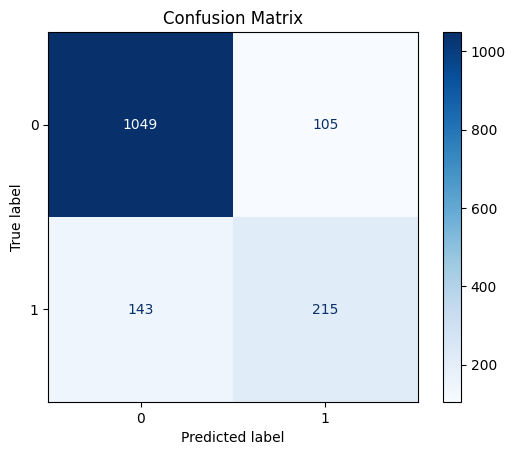

In [108]:
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show();

### Comparison of Performance Across Different Data Preprocessing Flows

Several training rounds were performed with different forms of data preprocessing. The table below shows the model training metrics for each data preprocessing flow:

| Métrica       | Colinearity Removal ✅  Winsorization ✅  SMOTE ✅ | Colinearity Removal 🚫  Winsorization ✅  SMOTE ✅ | Colinearity Removal ✅  Winsorization 🚫  SMOTE ✅ | Colinearity Removal 🚫  Winsorization 🚫  SMOTE ✅ |
|--------------|---------------------------------|---------------------------------|---------------------------------|---------------------------------|
| **Class 0 - Precision** | 0.89 | 0.89 | 0.88 | 0.89 |
| **Class 0 - Recall**    | 0.90 | 0.90 | 0.91 | 0.91 |
| **Class 0 - F1-score**  | 0.90 | 0.90 | 0.89 | 0.90 |
| **Class 1 - Precision** | 0.67 | 0.67 | 0.67 | 0.69 |
| **Class 1 - Recall**    | 0.63 | 0.63 | 0.60 | 0.66 |
| **Class 1 - F1-score**  | 0.65 | 0.65 | 0.63 | 0.67 |
| **Accuracy**            | 0.84 | 0.84 | 0.84 | 0.85 |
| **Macro Avg - Precision** | 0.78 | 0.78 | 0.78 | 0.79 |
| **Macro Avg - Recall**    | 0.77 | 0.77 | 0.75 | 0.78 |
| **Macro Avg - F1-score**  | 0.77 | 0.77 | 0.76 | 0.79 |
| **Weighted Avg - Precision** | 0.84 | 0.84 | 0.83 | 0.85 |
| **Weighted Avg - Recall**    | 0.84 | 0.84 | 0.84 | 0.85 |
| **Weighted Avg - F1-score**  | 0.84 | 0.84 | 0.83 | 0.85 |

*Results without SMOTE were significantly worse, so they were not included in this table. Results with UMAP were removed as well.*

# Conclusion

As we can see, our RandomForest model performed better without both collinearity removal and winsorization. So let's re-preprocess our dataset and retrain our model.

In [139]:
def preprocess_data(df: pd.DataFrame, target_col: str):
    # Remove missing values
    df = df.dropna()

    # Rename columns for clarity
    df = df.rename(columns={'RainToday': 'RainYesterday', 'RainTomorrow': 'RainToday'})

    # Filter for specific locations
    locations = ['Melbourne', 'MelbourneAirport', 'Watsonia']
    df = df[df['Location'].isin(locations)]

    # Convert Date column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Create a new column for seasons based on the date
    df['Season'] = df['Date'].apply(date_to_season)

    # Drop the Date column as it is no longer needed
    df = df.drop(columns=['Date'])

    # Convert categorical values to numerical format
    df["RainToday"] = df["RainToday"].map({"No": 0, "Yes": 1})

    # Split into features (X) and target variable (y)
    X = df.drop(columns=[target_col])
    y = df[target_col]

    return df, X, y

In [140]:
# Get dataset from url
df = pd.read_csv(url)

# Preprocess data and create feature and target sets
df, X, y = preprocess_data(df, target_col='RainToday')

X.sample(10)

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
65170  MelbourneAirport      9.4     19.3       0.0          2.2       2.1   
65201  MelbourneAirport     13.0     27.7       0.2          2.8       9.0   
66195  MelbourneAirport     12.9     15.0      16.2          9.0       0.8   
78987          Watsonia      7.4     20.9       0.0          3.2      12.5   
64462  MelbourneAirport      5.5     19.2       0.8          2.2       8.4   
78074          Watsonia     11.2     20.0       0.0          5.4       9.4   
79105          Watsonia     15.8     25.3       0.8          4.0       6.6   
64547  MelbourneAirport     13.1     38.6       0.0          6.2      11.3   
67255         Melbourne      3.2     14.3       0.0          1.6       5.1   
79472          Watsonia      8.7     17.1       2.0          5.4       1.6   

      WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity9am  \
65170          NW           33.0        NNE        NNW  ...         95.0   
65201         SSE           37.0         NE          S  ...         81.0   
66195         SSW           41.0        SSW          S  ...         91.0   
78987           S           28.0          E        WSW  ...         72.0   
64462           N           48.0        NNW         NE  ...         57.0   
78074          SW           28.0          W         SW  ...         72.0   
79105         WSW           37.0          S        SSW  ...         76.0   
64547          NW           59.0          E         NW  ...         66.0   
67255           N           37.0          N          N  ...         75.0   
79472           N           41.0         NE          N  ...         99.0   

       Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
65170         87.0       1013.8       1011.3       7.0       7.0     12.2   
65201         47.0       1013.8       1009.8       7.0       3.0     15.7   
66195         70.0       1017.4       1017.8       8.0       7.0     13.2   
78987         53.0       1022.1       1019.9       6.0       2.0     11.9   
64462         45.0       1015.8       1011.5       6.0       4.0     11.6   
78074         48.0       1026.9       1025.1       7.0       4.0     13.3   
79105         55.0       1015.6       1013.9       7.0       7.0     17.9   
64547         13.0       1010.4       1006.5       2.0       4.0     20.5   
67255         48.0       1028.1       1023.5       2.0       7.0      6.0   
79472         74.0       1007.2       1007.4       7.0       6.0     11.6   

       Temp3pm  RainYesterday  Season  
65170     15.2             No  Spring  
65201     25.9             No  Spring  
66195     14.4            Yes  Spring  
78987     19.9             No  Spring  
64462     18.4             No  Spring  
78074     18.5             No  Autumn  
79105     23.4             No  Summer  
64547     35.7             No  Summer  
67255     13.3             No  Winter  
79472     15.8            Yes  Autumn  

[10 rows x 22 columns]

In [122]:
# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Get column names
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Update our pipeline
model_pipeline.set_params(preprocessor=preprocessor)

# Retrain only with the top features
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   7.3s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   7.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   7.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=300; total time=   7.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2,

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pr...
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [True],
                         'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__max_features': ['sqrt', 'log2'],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [300, 400, 500]},
             scoring='accuracy', verbose=2)

### Classification Report

In [126]:
y_pred = grid_search.best_estimator_.predict(X_test)

print('Classification Report for updated data preprocessing:')
print(classification_report(y_test, y_pred))

Classification Report for updated data preprocessing:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1154
           1       0.68      0.64      0.66       358

    accuracy                           0.84      1512
   macro avg       0.79      0.77      0.78      1512
weighted avg       0.84      0.84      0.84      1512



### Confusion Matrix

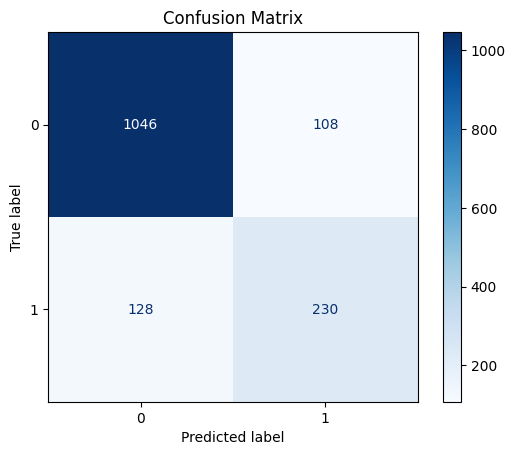

In [127]:
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show();

# Extracting feature importances

In order to understand how the dataset influences the predictions of our model, we will extract the feature importances and identify the features with the most effect on the target variable.

In [ ]:
# Associate feature importances with their original input variables
cat_features_backward = list(
  	grid_search.best_estimator_['preprocessor']
	.named_transformers_['cat']
	.named_steps['onehot']
	.get_feature_names_out(categorical_features)
)

# Combine numeric and categorical feature names
feature_names = numeric_features + cat_features_backward

feature_importances = grid_search.best_estimator_['classifier'].feature_importances_
importance_df = pd.DataFrame({
  	'Feature': feature_names,
  	'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

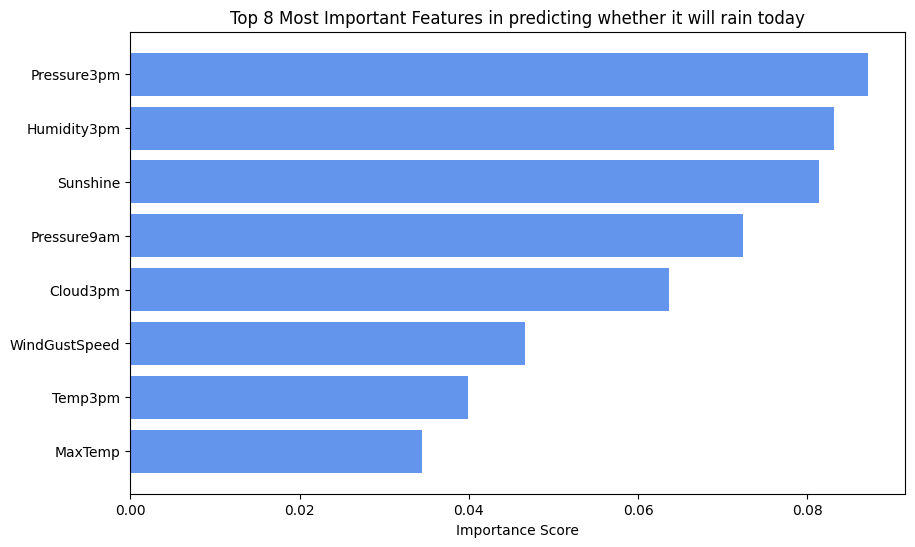

In [ ]:
# Plot importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='cornflowerblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Features importances in predicting whether it will rain today')
plt.xlabel('Importance Score')
plt.show();

In [ ]:
n_selected_features = 8
top_features = importance_df[:n_selected_features]

# Plot importances
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='cornflowerblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Top {n_selected_features} Most Important Features in predicting whether it will rain today')
plt.xlabel('Importance Score')
plt.show();

# Using best features

Now that we know which are the best features for our model, let's train another model using them and see if can we improve it even more.

In [144]:
X_tf = df[top_features['Feature']]
y_tf = df['RainToday']

X_tf.head()

Pressure3pm  Humidity3pm  Sunshine  Pressure9am  Cloud3pm  \
64191       1006.4         37.0       8.8       1005.1       7.0   
64192       1019.3         43.0      12.9       1018.0       7.0   
64193       1017.6         35.0      10.5       1020.8       7.0   
64194       1012.8         23.0      12.5       1016.2       4.0   
64195       1010.3         31.0      12.3       1011.9       2.0   

       WindGustSpeed  Temp3pm  MaxTemp  
64191           69.0     18.1     19.9  
64192           56.0     15.8     17.8  
64193           31.0     19.6     21.1  
64194           35.0     28.2     29.2  
64195           33.0     27.1     29.0

In [145]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y_tf, test_size=0.2, stratify=y, random_state=42)

# Get column names
numeric_features_tf = X_train_tf.select_dtypes(include=['number']).columns.tolist()
categorical_features_tf = X_train_tf.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer_tf = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer_tf = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_tf = ColumnTransformer(transformers=[
    ('num', numeric_transformer_tf, numeric_features_tf),
    ('cat', categorical_transformer_tf, categorical_features_tf)
])

# Update our pipeline
model_pipeline.set_params(preprocessor=preprocessor_tf)

# Retrain only with the top features
grid_search.fit(X_train_tf, y_train_tf)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   5.8s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   5.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   5.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   5.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5,

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Pressure3pm',
                                                                          'Humidity3pm',
                                                                          'Sunshine',
                                                                          'Pressure9am',
                                                                          'Cloud3pm',
                                                                          'WindGustSpeed',
                                                                          'Temp3pm',
                                                                          'MaxTemp']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncode...
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [True],
                         'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__max_features': ['sqrt', 'log2'],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [300, 400, 500]},
             scoring='accuracy', verbose=2)

Now we evaluate the model trained over the top features.

In [146]:
print("Best parameters found: ", grid_search.best_params_)

# Get best scoring during cross-validation
print("Best training score: {:.2f}".format(grid_search.best_score_))

# Now get scoring for test data
print("Test set score: {:.2f}".format(grid_search.score(X_test_tf, y_test_tf)))

# Get the best estimator and do some predictions on unseen data
y_pred_tf = grid_search.best_estimator_.predict(X_test_tf)

print("Classification Report for top features:")
print(classification_report(y_test_tf, y_pred_tf))

Best parameters found:  {'classifier__bootstrap': True, 'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 400}
Best training score: 0.84
Test set score: 0.84
Classification Report for top features:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1154
           1       0.66      0.72      0.68       358

    accuracy                           0.84      1512
   macro avg       0.78      0.80      0.79      1512
weighted avg       0.85      0.84      0.85      1512



As we can see, for the 'Yes' class recall increased from 0.66 to 0.74 which means that we have less instaces being misclassified as false positives. F1 score went from 0.68 to 0.70. Precision for the 'No' class also increased to 0.92 (previously 0.90). The precision for 'Yes' dropped from 0.70 to 0.67 but we still got good results as we can see at the confusion matrix.

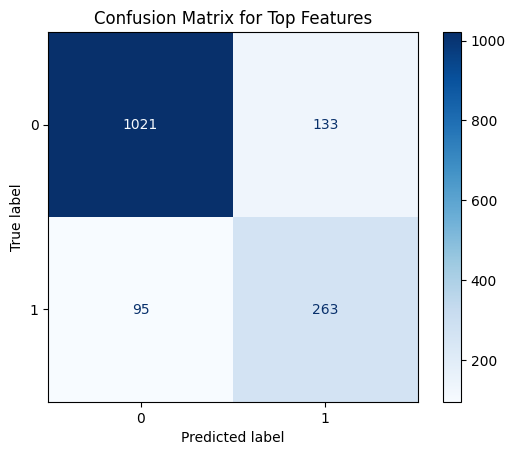

In [78]:
# Let's take a look at the confusion matrix for this new model
conf_matrix_tf = confusion_matrix(y_test_tf, y_pred_tf)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_tf)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Top Features')
plt.show();

# Using Boosting Techniques

Even after implementing SMOTE to balance the target class, setting class_weight="balanced" and using the best features, our results are still not the best.

Let's try a more sophisticated model like XGBoost, which is an advanced implementation of gradient boosting with the same general framework.

In [41]:
# Calculate the ratio between classes
scale_pos_weight = df["RainToday"].value_counts()[0] / df["RainToday"].value_counts()[1]

# Create XGBoost Model
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)

# Use another param_grid
param_grid_xgb = {
    "classifier__n_estimators": [100, 200, 500],
    "classifier__max_depth": [3, 6, 9],
    "classifier__learning_rate": [0.01, 0.1, 0.2]
}

model_pipeline.set_params(classifier=xgb_model)
grid_search.param_grid = param_grid_xgb
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.3s
[CV] END classifie

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Pressure3pm',
                                                                          'Sunshine',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Cloud3pm',
                                                                          'WindGustSpeed',
                                                                          'Temp3pm']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_u...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 6, 9],
                         'classifier__n_estimators': [100, 200, 500]},
             scoring='accuracy', verbose=2)

# XGBoost Evaluation


In [42]:
print("Best parameters found: ", grid_search.best_params_)

# Get best scoring during cross-validation
print("Best training score: {:.2f}".format(grid_search.best_score_))

# Now get scoring for test data
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

# Get the best estimator and do some predictions on unseen data
y_pred_boost = grid_search.best_estimator_.predict(X_test)

print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_boost))

Best parameters found:  {'classifier__learning_rate': 0.2, 'classifier__max_depth': 9, 'classifier__n_estimators': 500}
Best training score: 0.84
Test set score: 0.84
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1154
           1       0.65      0.73      0.69       358

    accuracy                           0.84      1512
   macro avg       0.78      0.80      0.79      1512
weighted avg       0.85      0.84      0.85      1512



Text(0.5, 1.0, 'Confusion Matrix for XGBoost')

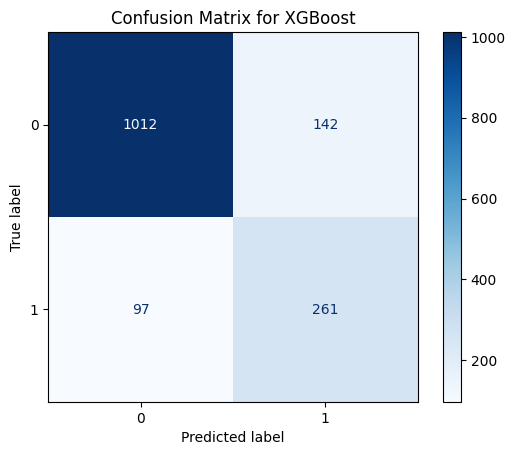

In [43]:
# Let's take a look at the confusion matrix for this new model
conf_matrix_boost = confusion_matrix(y_test, y_pred_boost)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_boost)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for XGBoost')

# Comparing results

As we can see, the XGBoost model achieved almost the same metrics as RandomForest in almost no time and without any fine-tuning like best feature selection. We also needed much less fits (135 vs 1080). This means that the XGBoost model is great choice to proceed with. 


| Metric       | Random Forest | XGBoost |
|--------------|--------------|---------|
| **Training Time** | 8m 57s | 9.9s |
| **Fits** | 1080 | 135 |
| **Class 0 - Precision** | 0.91 | 0.91 |
| **Class 0 - Recall**    | 0.88 | 0.88 |
| **Class 0 - F1-score**  | 0.90 | 0.89 |
| **Class 1 - Precision** | 0.66 | 0.65 |
| **Class 1 - Recall**    | 0.73 | 0.73 |
| **Class 1 - F1-score**  | 0.70 | 0.69 |
| **Accuracy**            | 0.85 | 0.84 |
| **Macro Avg - Precision** | 0.79 | 0.78 |
| **Macro Avg - Recall**    | 0.81 | 0.80 |
| **Macro Avg - F1-score**  | 0.80 | 0.79 |
| **Weighted Avg - Precision** | 0.86 | 0.85 |
| **Weighted Avg - Recall**    | 0.85 | 0.84 |
| **Weighted Avg - F1-score**  | 0.85 | 0.85 |



_Note that training times may vary accordingly to the machine used to run the project._ 

In [ ]:
param_grid_xgb_new = {
    "classifier__n_estimators": [300, 500],  # Teste diferentes números de árvores
    "classifier__max_depth": [9, 12],  # Aumentei para incluir árvores mais profundas
    "classifier__learning_rate": [0.1],  # Mais valores para um ajuste fino
    "classifier__subsample": [0.7, 0.8, 1.0],  # Evita overfitting reduzindo amostragem por árvore
    "classifier__colsample_bytree": [0.7, 0.8, 1.0],  # Quantidade de features usadas por árvore
    "classifier__gamma": [0, 0.1, 0.3, 0.5],  # Controla complexidade do modelo (pruning)
    "classifier__min_child_weight": [1, 3, 5],  # Aumenta restrição para evitar overfitting
    "classifier__reg_alpha": [0, 0.01, 0.1, 1],  # Regularização L1 (sparsity)
    "classifier__reg_lambda": [0.1, 1, 10],  # Regularização L2
}

grid_search.param_grid = param_grid_xgb_new
# grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=9, classifier__min_child_weight=1, classifier__n_estimators=300, classifier__reg_alpha=0, classifier__reg_lambda=0.1, classifier__subsample=0.8; total time=   1.9s
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=9, classifier__min_child_weight=1, classifier__n_estimators=300, classifier__reg_alpha=0, classifier__reg_lambda=0.1, classifier__subsample=0.7; total time=   2.0s
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=9, classifier__min_child_weight=1, classifier__n_estimators=300, classifier__reg_alpha=0, classifier__reg_lambda=0.1, classifier__subsample=1.0; total time=   2.0s
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0, classifier__learning_rate=0

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Pressure3pm',
                                                                          'Sunshine',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Cloud3pm',
                                                                          'WindGustSpeed',
                                                                          'Temp3pm']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_u...
             param_grid={'classifier__colsample_bytree': [0.7, 0.8, 1.0],
                         'classifier__gamma': [0, 0.1, 0.3, 0.5],
                         'classifier__learning_rate': [0.1],
                         'classifier__max_depth': [9, 12],
                         'classifier__min_child_weight': [1, 3, 5],
                         'classifier__n_estimators': [300, 500],
                         'classifier__reg_alpha': [0, 0.01, 0.1, 1],
                         'classifier__reg_lambda': [0.1, 1, 10],
                         'classifier__subsample': [0.7, 0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [50]:
print("Best parameters found: ", grid_search.best_params_)

# Get best scoring during cross-validation
print("Best training score: {:.2f}".format(grid_search.best_score_))

# Now get scoring for test data
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

# Get the best estimator and do some predictions on unseen data
y_pred_boost_2 = grid_search.best_estimator_.predict(X_test)

print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_boost_2))

Best parameters found:  {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 12, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 300, 'classifier__reg_alpha': 0, 'classifier__reg_lambda': 0.1, 'classifier__subsample': 0.7}
Best training score: 0.84
Test set score: 0.84
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1154
           1       0.64      0.74      0.69       358

    accuracy                           0.84      1512
   macro avg       0.78      0.81      0.79      1512
weighted avg       0.85      0.84      0.85      1512



Text(0.5, 1.0, 'Confusion Matrix for XGBoost')

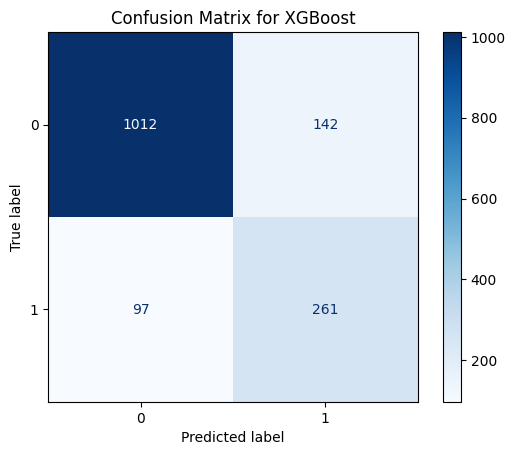

In [53]:
# Let's take a look at the confusion matrix for this new model
conf_matrix_boost = confusion_matrix(y_test, y_pred_boost)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_boost)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for XGBoost')